In [24]:
#Import relevant libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorboard.plugins.hparams import api as hp

In [25]:
#Define the hyperparameters
BUFFER_SIZE = 70_000
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [26]:
#Download the dataset
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info = True, as_supervised=True)

mnist_train, mnist_test = mnist_dataset['train'],  mnist_dataset['test']


#Scaling the dataset. Fist cast the image to avoid value error
def scale(image,label):
    image = tf.cast(image, tf.float32)
    image /= 225.
    
    return image, label
    

In [27]:
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

#creating the number of validation dataset from the training dataset
num_validation_samples = 0.1*mnist_info.splits['train'].num_examples

#convert number of the validation sample to an integer to prevent potential issue
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

#get the number data point in our  test samples
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

#Shuffle the training and validation dataset
shuffle_train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)


#create the train data
train_data = shuffle_train_and_validation_data.skip(num_validation_samples)

#create the validation data
validation_data = shuffle_train_and_validation_data.take(num_validation_samples)


#batching the training data

train_data = train_data.batch(BATCH_SIZE)

#No need to batch the validation and test data(we are not backpropagating on them ). Hence we will take all at once]
validation_data = validation_data.batch(num_validation_samples)

test_data = test_data.batch(num_test_samples)

validation_inputs, validation_targets = next(iter(validation_data))




 

In [30]:
#Define the hyperparamets to tune and the variations we want to test.
HP_FILTER_SIZE = hp.HParam('filter_size', hp.Discrete([3,5,7]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_FILTER_SIZE, HP_OPTIMIZER], 
        metrics= [hp.Metric(METRIC_ACCURACY, display_name='Accuracy')]
    )

In [33]:
model = Sequential([
            Conv2D(50, 3, activation= 'relu', input_shape=(28,28,1)),
            MaxPooling2D(pool_size=(2,2)),
            Conv2D(50, 3, activation= 'relu'),
            MaxPooling2D(pool_size=(2,2)),
            Flatten(),
            Dense(10)
])
    
    
#describe the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#Compile the model

model.compile(optimizer='adam', loss=loss_fn, metrics=[METRIC_ACCURACY])
        



In [36]:
#CREATE THE MODEL AND TRAIN IT

def train_model(hparams):
    
    
#Stop the model from overfitting ie whenever the validation loss increases
#the code tells the model to stop when the val_loss starts to increase in two subsequent epics

    early_stopping = EarlyStopping(
        monitor= 'val_loss',
        mode = 'auto',
        min_delta = 0,
        patience = 2,
        verbose = 0,
        restore_best_weights = True
    )

#    log_dir = "logs/hparam_tuning"
#    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
#Train the model
    model.fit(
        train_data,
        epochs = NUM_EPOCHS,
        callbacks = [early_stopping],
        validation_data = validation_data,
        verbose =2
    )

    _,accuracy = model.evaluate(test_data)
        
    return accuracy
   

In [37]:
def run(log_dir,hparams):
    
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams) #record the values used in this trial
        accuracy = train_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [38]:
#Train the model with the different hyperparameters
session_num = 0
for filter_size in HP_FILTER_SIZE.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
        hparams ={
        HP_FILTER_SIZE: filter_size,
        HP_OPTIMIZER : optimizer
        }
        
        run_name = "run-%d" % session_num
        print('---Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        
        session_num += 1

        

---Starting trial: run-0
{'filter_size': 3, 'optimizer': 'adam'}
Epoch 1/20
422/422 - 38s - loss: 0.2805 - accuracy: 0.9229 - val_loss: 0.0879 - val_accuracy: 0.9738 - 38s/epoch - 90ms/step
Epoch 2/20
422/422 - 36s - loss: 0.0761 - accuracy: 0.9767 - val_loss: 0.0662 - val_accuracy: 0.9773 - 36s/epoch - 86ms/step
Epoch 3/20
422/422 - 37s - loss: 0.0562 - accuracy: 0.9824 - val_loss: 0.0430 - val_accuracy: 0.9872 - 37s/epoch - 88ms/step
Epoch 4/20
422/422 - 37s - loss: 0.0469 - accuracy: 0.9861 - val_loss: 0.0398 - val_accuracy: 0.9883 - 37s/epoch - 87ms/step
Epoch 5/20
422/422 - 36s - loss: 0.0387 - accuracy: 0.9883 - val_loss: 0.0320 - val_accuracy: 0.9922 - 36s/epoch - 86ms/step
Epoch 6/20
422/422 - 36s - loss: 0.0359 - accuracy: 0.9885 - val_loss: 0.0313 - val_accuracy: 0.9903 - 36s/epoch - 84ms/step
Epoch 7/20
422/422 - 36s - loss: 0.0289 - accuracy: 0.9911 - val_loss: 0.0257 - val_accuracy: 0.9912 - 36s/epoch - 85ms/step
Epoch 8/20
422/422 - 36s - loss: 0.0266 - accuracy: 0.9919 -

In [39]:
# model.summary(line_length=75)

188/188 [==============================] - 2s 10ms/step


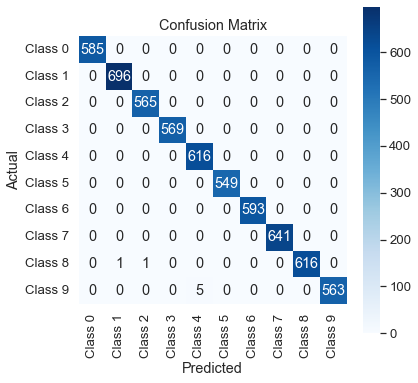

In [40]:
# # Create a Confusion Matrix

def make_predictions(val_images):
    predictions = model.predict(val_images)
    return predictions

for images, labels in validation_data:
    val_images = images.numpy()
    val_labels = labels.numpy()
    
val_predict_raw= make_predictions(val_images)
val_predict = np.argmax(val_predict_raw, axis =1)


cm = confusion_matrix(val_labels, val_predict)

# Define class labels
class_labels = ["Class 0", "Class 1", "Class 2","Class 3","Class 4","Class 5","Class 6","Class 7","Class 8","Class 9"]

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(6, 6))
sns.set(font_scale=1.2)  # Adjust the font size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True,
            xticklabels=class_labels,
            yticklabels=class_labels)


# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
# disp.plot(cmap="Blues", values_format="d")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [57]:
# #VISUALIZING IN TENSORBOARD BY 

# #Get the current date and time as a string
# current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# 
# #Create a log directory to create a directory of each run using the current date and time.

# log_dir = f'./logs/{current_datetime}'

# #create a tensorboard callback
# tensorboard_callback = tf.keras.callback.TensorBoard(log_dir=log_dir,histogram_freq=1)



In [63]:
# #Test the model
# test_loss, test_accuracy = model.evaluate(test_data)

# print(f'Test Loss: {round(test_loss,2)}. Test Accuracy:{round(test_accuracy*100,2)}%')

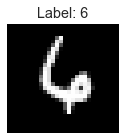

In [45]:

#PLOT THE IMAGE AND RESULT

# Get and display the nth images from the training dataset. n=1
num_images_to_display = 1
for image, label in test_data.take(num_images_to_display):
    sample_image = image.numpy()# Convert to numpy array and remove singleton dimensions
    sample_label = label.numpy()

original_images = sample_image.reshape(10000, 28, 28)

# Display the image using matplotlib
image_number_to_display = 900

plt.figure(figsize=(2,2))
plt.imshow(sample_image[image_number_to_display], cmap='gray', aspect="auto")
plt.title(f'Label: {sample_label[image_number_to_display]}')
plt.axis('off')  # Turn off axis
plt.show()

1/1 [==============================] - 0s 34ms/step


<BarContainer object of 10 artists>

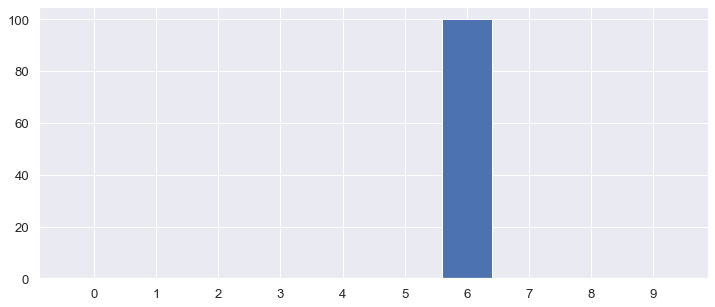

In [46]:
#Obtain the model's prediction(logits)

#Using slicing is important because tensorflow expects inputs to be in batches.
predictions = make_predictions(sample_image[image_number_to_display:image_number_to_display+1])

#Convert the predictions into probabilities and to percentage
probabilities = (tf.nn.softmax(predictions).numpy()) *100

#Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0", "1","2","3","4","5","6","7","8","9"])

In [49]:
# #Load Tensorboard using the commands
# %load_ext tensorboard
# %tensorboard --logdir "logs/hparam_tuning"

